# GLM Basics

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadr
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import d2_tweedie_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.max_columns', None, 'display.max_rows', None)

# Import Data
You can download the sample data <a href="https://github.com/henckr/maidrr/blob/master/data/mtpl_be.rda">here</a>. Data dictionary is available <a href="https://henckr.github.io/maidrr/reference/mtpl_be.html">here</a>.
* <b><i>id</i></b>: policyholder id
* <b><i>nclaims</i></b>: number of claims
* <b><i>coverage</i></b>: converage type as TPL, TPL+ or TPL++
* <b><i>expo</i></b>: exposure period, as a fraction of a year
* <b><i>ageph</i></b>: age of the policyholder, in years
* <b><i>sex</i></b>: female or male
* <b><i>bm</i></b>: bonus-malus level, higher is worse
* <b><i>power</i></b>: horsepower of the vehicle, in kilowatt
* <b><i>agec</i></b>: age of the vehicle, in years
* <b><i>fuel</i></b>: diesel or gasoline
* <b><i>use</i></b>: private or work
* <b><i>fleet</i></b>: 0 or 1
* <b><i>postcode</i></b>: first two digits of the postal code of the municipality of residence

In [2]:
df = pyreadr.read_r('mtpl_be.rda')['mtpl_be']

In [3]:
print(df.shape)
display(df.head())

(163210, 13)


,id,expo,nclaims,coverage,ageph,sex,bm,power,agec,fuel,use,fleet,postcode
0,1,1.000000,1,TPL,50,male,5,77,12,gasoline,private,no,10
1,2,1.000000,0,TPL+,64,female,5,66,3,gasoline,private,no,10
2,3,1.000000,0,TPL,60,male,0,70,10,diesel,private,no,10
3,4,1.000000,0,TPL,77,male,0,57,15,gasoline,private,no,10
4,5,0.046575,1,TPL,28,female,9,70,7,gasoline,private,no,10


Average Frequency = 0.1391800048491219
Fraction of exposure with zero claims = 88.3%


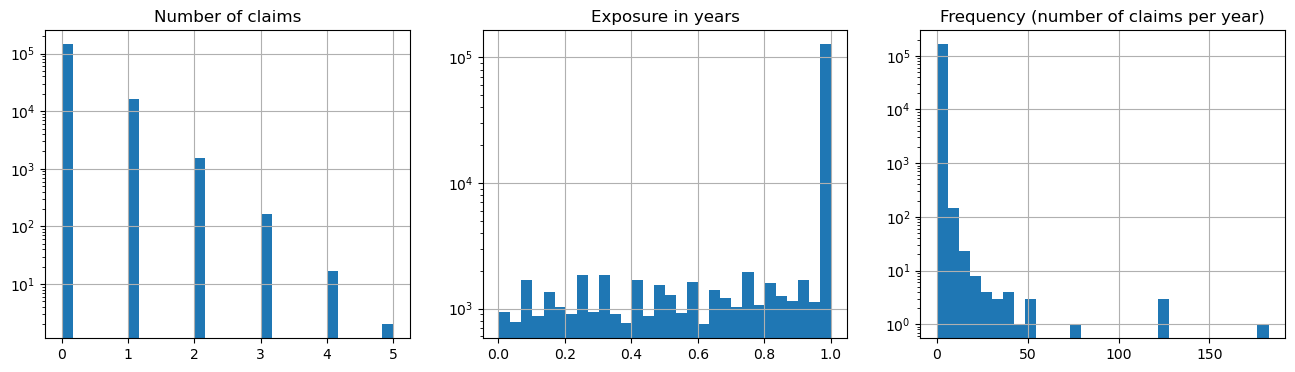

In [4]:
df["freq"] = df["nclaims"] / df["expo"]

print(
    "Average Frequency = {}".format(np.average(df["freq"], weights=df["expo"]))
)

print(
    "Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["nclaims"] == 0, "expo"].sum() / df["expo"].sum()
    )
)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))

ax0.set_title("Number of claims")
_ = df["nclaims"].hist(bins=30, log=True, ax=ax0)

ax1.set_title("Exposure in years")
_ = df["expo"].hist(bins=30, log=True, ax=ax1)

ax2.set_title("Frequency (number of claims per year)")
_ = df["freq"].hist(bins=30, log=True, ax=ax2)

# Preprocess Data
For learning purposes, we will only use coverage and policy holder's age & gender.
* Use the most populated category as the reference category.

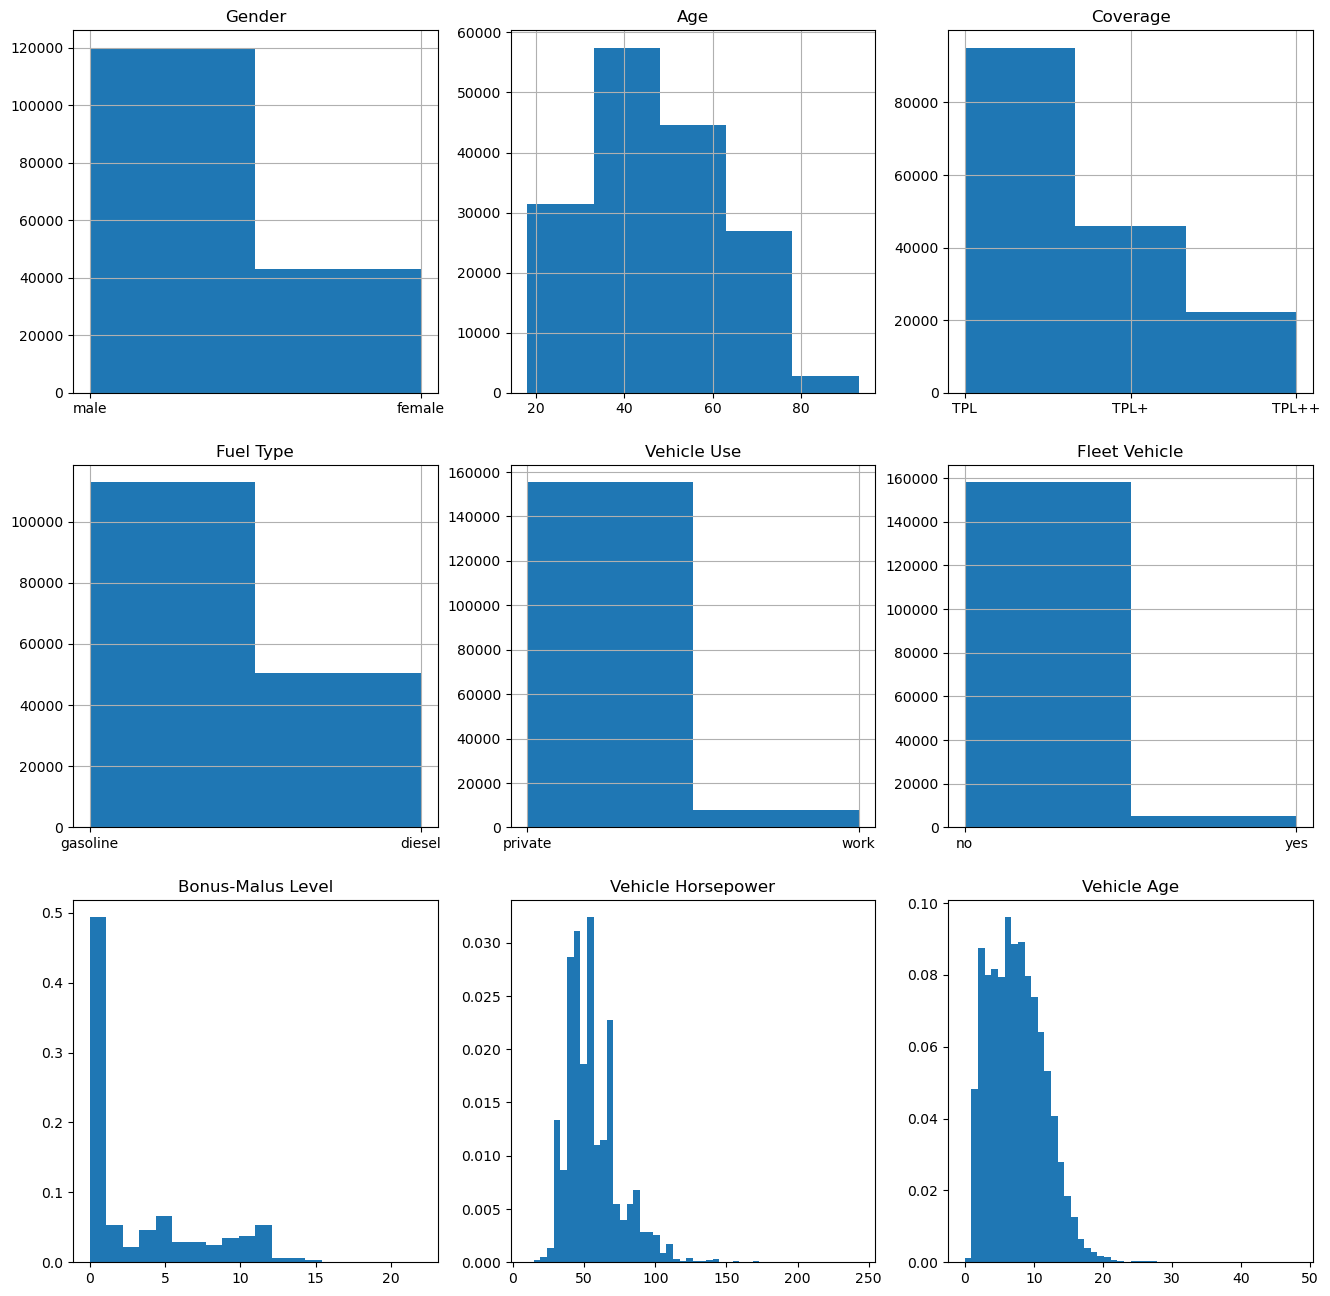

In [5]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16,16))

axs[0,0].set_title("Gender")
_ = df["sex"].hist(bins=2, ax=axs[0,0])

axs[0,1].set_title("Age")
_ = df["ageph"].hist(bins=range(df.ageph.min(),df.ageph.max()+1,15), ax=axs[0,1])

axs[0,2].set_title("Coverage")
_ = df["coverage"].hist(bins=3, ax=axs[0,2])

axs[1,0].set_title("Fuel Type")
_ = df["fuel"].hist(bins=2, ax=axs[1,0])

axs[1,1].set_title("Vehicle Use")
_ = df["use"].hist(bins=2, ax=axs[1,1])

axs[1,2].set_title("Fleet Vehicle")
_ = df["fleet"].hist(bins=2, ax=axs[1,2])

axs[2,0].set_title("Bonus-Malus Level")
axs[2,0].hist(df["bm"], density=True, bins=20);

axs[2,1].set_title("Vehicle Horsepower")
axs[2,1].hist(df["power"], density=True, bins=50);

axs[2,2].set_title("Vehicle Age")
axs[2,2].hist(df["agec"], density=True, bins=50);

In [6]:
# one-hot encode gender
# ref: male
def female(row):
    if row["sex"]!="male":
        return 1
    else:
        return 0
    
# one-hot encode coverage
# ref: TPL
def tpl1p(row):
    if row["coverage"]=="TPL+":
        return 1
    else:
        return 0

def tpl2p(row):
    if row["coverage"]=="TPL++":
        return 1
    else:
        return 0
    
# one-hot encode age
# ref: 33-47
# younger than 33
def age1(row):
    if row["ageph"]<df.ageph.min()+15:
        return 1
    else:
        return 0

# btw 33 and 47 (ref)
def age2(row):
    if row["ageph"]>=df.ageph.min()+(15*1) and row["ageph"]<df.ageph.min()+(15*2):
        return 1
    else:
        return 0

# btw 48 and 62
def age3(row):
    if row["ageph"]>=df.ageph.min()+(15*2) and row["ageph"]<df.ageph.min()+(15*3):
        return 1
    else:
        return 0

# btw 63 and 77
def age4(row):
    if row["ageph"]>=df.ageph.min()+(15*3) and row["ageph"]<df.ageph.min()+(15*4):
        return 1
    else:
        return 0

# older than 77
def age5(row):
    if row["ageph"]>=df.ageph.min()+(15*4):
        return 1
    else:
        return 0

In [7]:
# apply one-hot encoders to the data
df["female"] = df.apply(female, axis=1)
df["tpl1p"] = df.apply(tpl1p, axis=1)
df["tpl2p"] = df.apply(tpl2p, axis=1)
df["age1"] = df.apply(age1, axis=1)
df["age3"] = df.apply(age3, axis=1)
df["age4"] = df.apply(age4, axis=1)
df["age5"] = df.apply(age5, axis=1)

In [8]:
# split data into train (70%) and test (30%)
weight = "expo"
target = "nclaims"
features = ["female", "tpl1p", "tpl2p", "age1", "age3", "age4", "age5"]
df_train, df_test = train_test_split(df[[weight]+[target]+features], test_size=0.3, random_state=0)

# EDA

### Association btw Features
* Use Cramer's V to detect categorical features that are related to each other.
* No strong correlation is found, so no concern for multicollinearity.

In [9]:
def cramers_v(var1,var2) :
    # build cross tab
    crosstab =np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
    # # of obs
    obs = np.sum(crosstab) 
    # take the min of cross tab's ncol and nrow
    mini = min(crosstab.shape)-1 
    # record the test statistic of the Chi2 test
    stat = stats.chi2_contingency(crosstab)[0]    
    return (stat/(obs*mini))

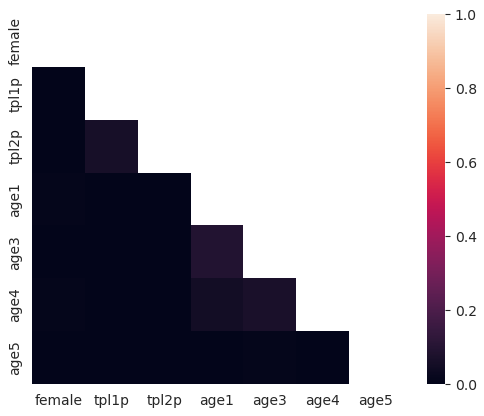

In [10]:
# conduct Cramer's V test
rows= []
for var1 in df_train[features]:
    col = []
    for var2 in df_train[features]:
        cramers = cramers_v(df_train[features][var1], df_train[features][var2]) 
        col.append(round(cramers,2)) 
    rows.append(col)

cramers_results = np.array(rows)
df_cramer = pd.DataFrame(cramers_results, columns=df_train[features].columns, index=df_train[features].columns)

# plot Cramer's V
mask = np.zeros_like(df_cramer, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(df_cramer, mask=mask,vmin=0.0, vmax=1.0, square=True)

plt.show()

# Train Model

### Individual Data

In [11]:
glm_ind = smf.glm(
    "nclaims ~ female + tpl1p + tpl2p + age1 + age3 + age4 + age5",
    data=df_train,
    family=sm.families.Poisson(),
    exposure=np.asarray(df_train[weight]),
)
res_ind = glm_ind.fit()
print("AIC:", res_ind.aic, "\n")
print(res_ind.summary())

AIC: 88777.38497184105 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nclaims   No. Observations:               114247
Model:                            GLM   Df Residuals:                   114239
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -44381.
Date:                Mon, 16 Oct 2023   Deviance:                       62244.
Time:                        11:46:41   Pearson chi2:                 1.36e+05
No. Iterations:                     6   Pseudo R-squ. (CS):           0.007039
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9141      

### Grouped Data
* Aggregate data by summing claim count and exposure by same characteristics.
* GLM results confirm that they are the same for individual and aggregate data.

In [12]:
# aggregate data by summing count and exposure by same characteristics 
data = df_train.copy()
data["nclaims"] = data[target]
data["expo"] = data[weight]
dfagg_train = (
    data["female tpl1p tpl2p age1 age3 age4 age5 nclaims expo".split()]
    .groupby("female tpl1p tpl2p age1 age3 age4 age5".split())
    .sum()
)
dfagg_train.reset_index(inplace=True)
dfagg_train["freq"] = dfagg_train[target]/dfagg_train[weight]
print(dfagg_train.shape)

(30, 10)


In [13]:
glm_agg = smf.glm(
    "nclaims ~ female + tpl1p + tpl2p + age1 + age3 + age4 + age5",
    data=dfagg_train,
    family=sm.families.Poisson(),
    exposure=np.asarray(dfagg_train[weight]),
)
res_agg = glm_agg.fit()
print("AIC:", res_agg.aic, "\n")
print(res_agg.summary())

AIC: 298.0871842578889 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nclaims   No. Observations:                   30
Model:                            GLM   Df Residuals:                       22
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -141.04
Date:                Mon, 16 Oct 2023   Deviance:                       66.304
Time:                        11:46:42   Pearson chi2:                     66.3
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9141      

### Feature Selection
* Step 1: female isn't statistically significant, so remove it  
* Step 2: fail to reject the null that female isn't relevant for explaining nclaims based on deviance  
* Step 3: AIC is lower without female (deviance never increases with more features, so use AIC)  

In [14]:
glm_agg_nofemale = smf.glm(
    "nclaims ~ tpl1p + tpl2p + age1 + age3 + age4 + age5",
    data=dfagg_train,
    family=sm.families.Poisson(),
    exposure=np.asarray(dfagg_train[weight]),
)
res_agg_nofemale = glm_agg_nofemale.fit()
print("AIC:", res_agg_nofemale.aic, "\n")
print(res_agg_nofemale.summary())

AIC: 296.64969838752233 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nclaims   No. Observations:                   30
Model:                            GLM   Df Residuals:                       23
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -141.32
Date:                Mon, 16 Oct 2023   Deviance:                       66.867
Time:                        11:46:42   Pearson chi2:                     67.1
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9098     

In [15]:
print("deviance results \n")
print("null deviance:", res_agg_nofemale.null_deviance)
print("glm female deviance:", res_agg.deviance, "   dof:", 7)
print("glm NO female deviance:", res_agg_nofemale.deviance, "   dof:", 6, "\n")
print("H0: female is not relevant for explaining nclaims")
print("p-value:", 1-stats.chi2.cdf(res_agg_nofemale.deviance-res_agg.deviance,1))

deviance results 

null deviance: 873.3821770302148
glm female deviance: 66.30412904406568    dof: 7
glm NO female deviance: 66.8666431737062    dof: 6 

H0: female is not relevant for explaining nclaims
p-value: 0.4532490315245191


### Diagnostics
* No clear pattern for residuals against fitted y.

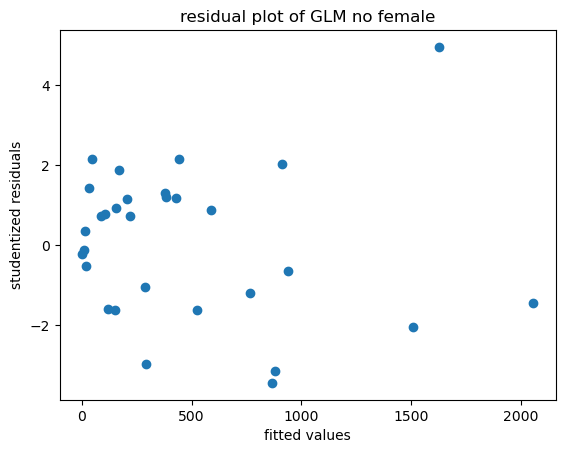

In [16]:
fitted_values = res_agg_nofemale.fittedvalues
studentized_residuals = res_agg_nofemale.get_influence().resid_studentized

plt.scatter(fitted_values, studentized_residuals)
plt.title("residual plot of GLM no female")
plt.xlabel("fitted values")
plt.ylabel("studentized residuals")
plt.show()

* The combined residual plot shows 3 pts in the upper and lower right parts of the graph (high hat and residual values). Thus, these 3 risk classes simultanrously exhibit large Cook's distances and leverages.
* Leverage only measures the potential to affect the fit whereas influence more directly measures the effect of each obs on the fit. 
    * Cook's distance indicates the influence of each X on fitted y, which is useful for identifying outliers in X values.
    * Hat matrix (leverage) measures the potential of an obs (X) to affect fitted values (y). Large leverages mean that the fit is sensitive to the response (the corresponding features are unusual in some way). 

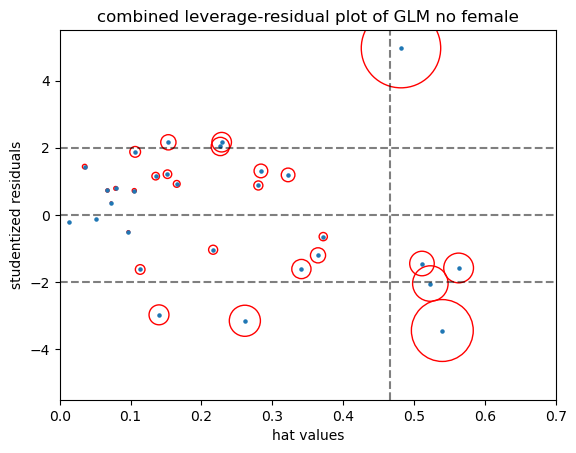

In [17]:
hat_values = res_agg_nofemale.get_hat_matrix_diag()
cooks_distance = res_agg_nofemale.get_influence().cooks_distance[0]
# set horizontal line twice and three times the average hat value
x_upper_limit_2 = np.mean(res_agg_nofemale.get_hat_matrix_diag())*2
x_upper_limit_3 = np.mean(res_agg_nofemale.get_hat_matrix_diag())*3

# red circle size proportional to Cook's distance
plt.scatter(hat_values, studentized_residuals, s=cooks_distance*1000, color="red", facecolors="none")
plt.scatter(hat_values, studentized_residuals, s=5)
plt.axvline(x=x_upper_limit_2, linestyle="dashed", alpha=0.5, color="black")
# set vertical line at -2, 0, and 2
plt.axhline(y=2, linestyle="dashed", alpha=0.5, color="black")
plt.axhline(y=0, linestyle="dashed", alpha=0.5, color="black")
plt.axhline(y=-2, linestyle="dashed", alpha=0.5, color="black")
plt.xlim(0, x_upper_limit_3)
plt.ylim(-5.5, 5.5)
plt.title("combined leverage-residual plot of GLM no female")
plt.xlabel("hat values")
plt.ylabel("studentized residuals")
plt.show()

In [18]:
# locate the 3 outlier classes
res_agg_nofemale.get_influence().summary_frame().sort_values("hat_diag", ascending=False).head(5)

,dfb_Intercept,dfb_tpl1p,dfb_tpl2p,dfb_age1,dfb_age3,dfb_age4,dfb_age5,cooks_d,standard_resid,hat_diag,dffits_internal
1,-0.067946,0.148028,0.082488,0.007450,-0.002883,-0.000569,-1.746223,0.458559,-1.578883,0.562868,-1753.828034
2,-0.460792,0.963972,0.614682,0.051314,-0.018423,-3.081265,0.014046,1.983925,-3.440316,0.539880,-31463.163298
3,-0.378314,0.745780,0.567879,0.043032,-1.527510,0.002449,0.013188,0.653198,-2.042151,0.522991,-25347.127049
0,-1.478655,0.565801,0.462795,0.903146,0.831539,0.674111,0.275872,0.312346,-1.446015,0.511159,-20514.753904
4,0.736770,-1.446478,-1.114166,3.293103,0.026769,-0.005194,-0.025899,3.270143,4.964416,0.481546,37204.808143


### Best GLM
* AIC improves after dropping the 3 outliers.
* Model predictions are in close agreement to portfolio's experience.

In [19]:
glm_agg_final = smf.glm(
    "nclaims ~ tpl1p + tpl2p + age1 + age3 + age4 + age5",
    data=dfagg_train.drop([2,3,4]),
    family=sm.families.Poisson(),
    exposure=np.asarray(dfagg_train.drop([2,3,4])[weight]),
)
res_agg_final = glm_agg_final.fit()
print("AIC:", res_agg_final.aic, "\n")
print(res_agg_final.summary())

AIC: 233.17279245500438 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nclaims   No. Observations:                   27
Model:                            GLM   Df Residuals:                       20
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -109.59
Date:                Mon, 16 Oct 2023   Deviance:                       30.344
Time:                        11:46:42   Pearson chi2:                     30.8
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9079     

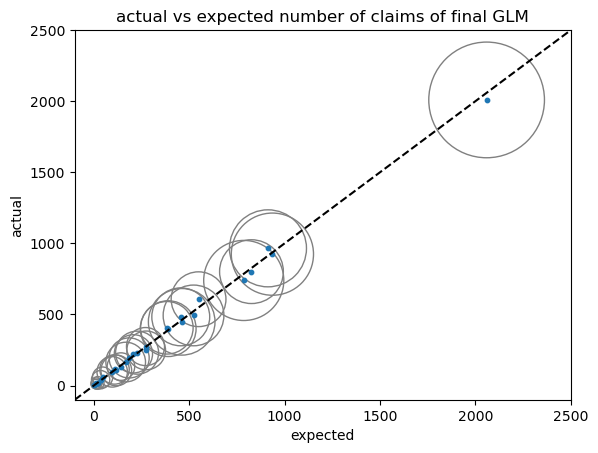

In [20]:
actual = dfagg_train.drop([2,3,4])[target]
expected = res_agg_final.fittedvalues
exposure = dfagg_train.drop([2,3,4])[weight]

# red circle size proportional to total exposure of each risk class
plt.scatter(expected, actual, s=exposure/2, color="grey", facecolors="none")
plt.scatter(expected, actual, s=10)
# 45-degree line
plt.axline((0,0), slope=1, linestyle='--', color="black")
plt.xlim(-100, 2500)
plt.ylim(-100, 2500)
plt.title("actual vs expected number of claims of final GLM")
plt.xlabel("expected")
plt.ylabel("actual")
plt.show()

# Test
* Model prediction accuracy on test data beats benchmark where mean from the training data is used.

In [21]:
# aggregate data by summing count and exposure by same characteristics 
data = df_test.copy()
data["nclaims"] = data["nclaims"]
data["expo"] = data["expo"]
dfagg_test = (
    data["female tpl1p tpl2p age1 age3 age4 age5 nclaims expo".split()]
    .groupby("female tpl1p tpl2p age1 age3 age4 age5".split())
    .sum()
)
dfagg_test.reset_index(inplace=True)
dfagg_test["freq"] = dfagg_test[target]/dfagg_test[weight]
print(dfagg_test.shape)

(30, 10)


A/E ratio for total # of claims
Dummy: 0.983
GLM: 0.983

Average of A/E ratios across all risk classes
Dummy: 0.952
GLM: 0.999

Fraction of deviance explained
Dummy: -0.004
GLM: 0.845


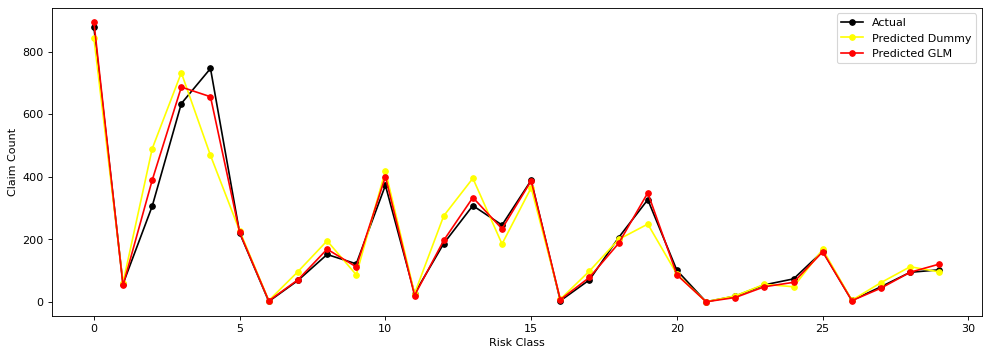

In [25]:
actual_vals = dfagg_test[target]
test_weight = dfagg_test[weight]
test_freq = dfagg_test["freq"]
predicted_vals_dummy = np.full(dfagg_test[target].shape, np.average(dfagg_train["freq"], weights=dfagg_train[weight]))
predicted_vals_glm = res_agg_final.predict(dfagg_test[features])

# A/E ratio
print("A/E ratio for total # of claims")
print("Dummy: %.3f"% (sum(actual_vals)/sum(predicted_vals_dummy*test_weight)))
print("GLM: %.3f"% (sum(actual_vals)/sum(predicted_vals_glm*test_weight)))
print("\nAverage of A/E ratios across all risk classes")
print("Dummy: %.3f"% (np.mean(actual_vals/(predicted_vals_dummy*test_weight))))
print("GLM: %.3f"% (np.mean(actual_vals/(predicted_vals_glm*test_weight))))

# fraction of Tweedie deviance explained
print("\nFraction of deviance explained")
print("Dummy: %.3f"% d2_tweedie_score(test_freq, predicted_vals_dummy, sample_weight=test_weight, power=1))
print("GLM: %.3f"% d2_tweedie_score(test_freq, predicted_vals_glm, sample_weight=test_weight, power=1))

# plot
plt.figure(figsize=(15,5), dpi=80)
plt.plot(actual_vals, "o-", ms=5, color="black", label="Actual")
plt.plot(predicted_vals_dummy*test_weight, "o-", ms=5, color="yellow", label="Predicted Dummy")
plt.plot(predicted_vals_glm*test_weight, "o-", ms=5, color="red", label="Predicted GLM")
plt.ylabel("Claim Count")
plt.xlabel("Risk Class")
plt.legend()
plt.show()